# Sample spatial query data

Prepare several geojson files based on Natural Earth's California shape.

In [1]:
import duckdb
from matplotlib import pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely

## Get US State Data

Set the output path for downloaded and exported data

In [2]:
outpath = 'data/spatial'

In [3]:
%%bash -s "$outpath"
mkdir -p $1
if [ ! -f $1/ne_10m_admin_1_states_provinces.zip ]; then curl -L -o $1/ne_10m_admin_1_states_provinces.zip "https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces.zip"; fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.2M  100 14.2M    0     0  26.3M      0 --:--:-- --:--:-- --:--:-- 26.3M


Subset states to California

In [4]:
admin1 = gpd.read_file(f'{outpath}/ne_10m_admin_1_states_provinces.zip')
usa_states = admin1[admin1.iso_a2 == 'US'][['name', 'geometry']]
usa_states = usa_states.rename(columns={'name': 'state_name'})
california = usa_states[usa_states["state_name"]=="California"]

## Vary Polygon Complexity

Count polygon vertices

In [5]:
# https://gis.stackexchange.com/a/457595
def geometry_flatten(geom):
  if hasattr(geom, 'geoms'):  # Multi<Type> / GeometryCollection
    for g in geom.geoms:
      yield from geometry_flatten(g)
  elif hasattr(geom, 'interiors'):  # Polygon
    yield geom.exterior
    yield from geom.interiors
  else:  # Point / LineString
    yield geom

def geometry_length(geom):
  return sum(len(g.coords) for g in geometry_flatten(geom))

In [6]:
ca_shp = california.iloc[0]['geometry']
print('ca_shp:')
print(f'  type: {type(ca_shp)}')
print(f'  vertex count: {geometry_length(ca_shp)}')

ca_shp:
  type: <class 'shapely.geometry.multipolygon.MultiPolygon'>
  vertex count: 1856


Reduce shape complexity

In [7]:
ca_simple = shapely.simplify(ca_shp, tolerance = 0.01) # tolerance in units of CRS: decimal degrees
print('ca_simple:')
print(f'  type: {type(ca_simple)}')
print(f'  vertex count: {geometry_length(ca_simple)}')
print(f'ca_simple has {int(geometry_length(ca_simple)/geometry_length(ca_shp)*100)}% the vertices of ca_shp')

ca_simple:
  type: <class 'shapely.geometry.multipolygon.MultiPolygon'>
  vertex count: 434
ca_simple has 23% the vertices of ca_shp


## Create Bounding Box

The bounding box will be a shapely polygon geometry object. Later we can convert it to other formats, like point geometry or a simple list of coordinates.

In [8]:
ca_bbox = shapely.envelope(ca_shp)
print(f'shapely.envelope returns object with type of {type(ca_bbox)}')

shapely.envelope returns object with type of <class 'shapely.geometry.polygon.Polygon'>


In [9]:
print(shapely.to_wkt(ca_bbox).replace(',', '\n         '))

POLYGON ((-124.409202 32.531669
          -114.119061 32.531669
          -114.119061 41.99954
          -124.409202 41.99954
          -124.409202 32.531669))


## Smaller Bounding Box

So that we can query generally the same region of the world with the same shape complexity, but with a smaller area.

In [10]:
ca_centroid = shapely.centroid(ca_shp)

In [11]:
list(ca_bbox.exterior.coords)

[(-124.4092019709999, 32.53166949000402),
 (-114.1190613217226, 32.53166949000402),
 (-114.1190613217226, 41.99954022140406),
 (-124.4092019709999, 41.99954022140406),
 (-124.4092019709999, 32.53166949000402)]

Coordinate order above: lower left, lower right, upper right, upper left, lower left (repeated to close polygon).  

Next, resize the bounding box by applying a resizing factor to the distance between the center and the lower left bounding box coordinate.

In [12]:
resize_factor = -0.50

ca_bbox_shrunk = (
  ca_bbox.buffer(resize_factor *
                 ca_centroid.distance(
                   shapely.geometry.Point(ca_bbox.exterior.coords[0])))
)
list(ca_bbox_shrunk.exterior.coords)

[(-121.04544405757561, 35.895427403428315),
 (-121.04544405757561, 38.63578230797977),
 (-117.48281923514689, 38.63578230797977),
 (-117.48281923514689, 35.895427403428315),
 (-121.04544405757561, 35.895427403428315)]

Plot the boxes with the original California shape

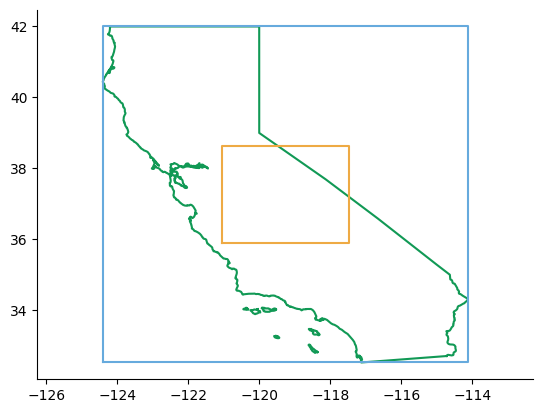

In [13]:
for poly in ca_shp.geoms: # California is a multipolygon
  plt.plot(*poly.exterior.xy, color = '#119955')
plt.plot(*ca_bbox.exterior.xy, color = '#66aadd')
plt.plot(*ca_bbox_shrunk.exterior.xy, color = '#eeaa44')
plt.axis('equal')
plt.subplot().spines[['right', 'top']].set_visible(False)
plt.show()

<span style="color:#119955">California (original resolution)</span>  
<span style="color:#66aadd">California (bounding box)</span>  
<span style="color:#eeaa44">California (shrunken bounding box)</span>  

## Bounding Box as Multipoint, Points, and Min/Max Columns

Convert the original bounding box to various other formats.

In [14]:
ca_bbox_multipoint = shapely.geometry.MultiPoint(ca_bbox.exterior.coords[0:4])

In [15]:
ca_bbox_points = [shapely.geometry.Point(p) for p in ca_bbox.exterior.coords[0:4]]

Didn't actually use the object below: it's easier to write a parquet file directly with geopandas so that the group column (of all four coordinates) is stored. Keeping this here for visual reference of what a bounding box looks like as four columns.

In [16]:
ca_bbox_x, ca_bbox_y = ca_bbox.exterior.xy
ca_bbox_columns = \
  pd.DataFrame({'min_x': [min(ca_bbox_x)],
                'min_y': [min(ca_bbox_y)],
                'max_x': [max(ca_bbox_x)],
                'max_y': [max(ca_bbox_y)]})
ca_bbox_columns

,min_x,min_y,max_x,max_y
0,-124.409202,32.531669,-114.119061,41.99954


## Write Output Geometries

We can use these geometries in our test plan to examine the impact varying shape parameters has on query performance.

In [17]:
california.to_file(f'{outpath}/ca_shp.geojson', driver='GeoJSON')

Combine shapely geometries into Geopandas dataframes. That allows us to include name properties that DuckDB will read as a column, and will allow us to differentiate which input query geometries were used in the results of later spatial joins.

In [18]:
for export_shape in ['ca_simple', 'ca_bbox', 'ca_bbox_shrunk',
                     'ca_bbox_multipoint', 'ca_centroid']:
  gdf = gpd.GeoDataFrame({'feature_name': [export_shape],
                          'geometry': globals()[export_shape]},
                          crs='EPSG:4326')
  gdf.to_file(f'{outpath}/{export_shape}.geojson',
              driver='GeoJSON')

The geodataframe with four separate points needs to be created slightly differently than the pattern above.

In [19]:
gpd.GeoDataFrame({
                    'feature_name':
                      list('ca_bbox_points_' + point_id for point_id in ['LL', 'LR', 'UR', 'UL']),
                    'geometry': ca_bbox_points
                 },
                 crs='EPSG:4326').to_file(
                   f'{outpath}/ca_bbox_points.geojson',
                   driver = 'GeoJSON'
                 )

## Test that DuckDB can load GeoJSON files

In [21]:
duckdb.sql('INSTALL SPATIAL; LOAD SPATIAL;')
duckdb.sql(f"SELECT * FROM ST_Read('{outpath}/ca_centroid.geojson')")

┌──────────────┬───────────────────────────────────────────────┐
│ feature_name │                     geom                      │
│   varchar    │                   geometry                    │
├──────────────┼───────────────────────────────────────────────┤
│ ca_centroid  │ POINT (-119.60590001319969 37.24205795622323) │
└──────────────┴───────────────────────────────────────────────┘

## Write bbox as separate columns

Geopandas' parquet writer (with `write_covering_bbox = True`) handles setting up the parquet schema so that the four bounding box coordinate columns are treated as a group column.

In [22]:
ca_bbox_in = gpd.read_file(f'{outpath}/ca_bbox.geojson')
ca_bbox_in.to_parquet(
  path = f'{outpath}/ca_bbox.parquet',
  write_covering_bbox = True
)

## Test loading the parquet bbox file in DuckDB

In [23]:
duckdb.sql(f"SELECT feature_name, bbox FROM parquet_scan('{outpath}/ca_bbox.parquet')")

┌──────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ feature_name │                                                      bbox                                                      │
│   varchar    │                           struct(xmin double, ymin double, xmax double, ymax double)                           │
├──────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ ca_bbox      │ {'xmin': -124.4092019709999, 'ymin': 32.53166949000402, 'xmax': -114.1190613217226, 'ymax': 41.99954022140406} │
└──────────────┴────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘